In [14]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')
from matplotlib.colors import LightSource
hcm = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","yellow","saddlebrown","grey","w"])
Hmax=2000
def show_H_stats(Hc,dx,shading=False,nzbins=65):
    ny,nx = np.shape(Hc)
    Hc_max = np.max(Hc)
    Hc_min = np.min(Hc)
    Hc_mean = np.mean(Hc)
    Hc_std = np.std(Hc)
    extent = (0,nx*dx/1000,0,ny*dx/1000)
    fig, ax = plt.subplots(ncols=2,figsize=(15,5))
    im = ax[0].imshow(Hc, cmap=hcm,vmin=0,vmax=Hmax, origin='lower',extent=extent,interpolation='none',visible=not(shading))
    if shading:
        ls = LightSource(325, 45)
        rgb = ls.shade(Hc, cmap=hcm,vmin=0,vmax=Hmax, vert_exag=Hc_max/Hmax/dx, blend_mode='soft')
        ax[0].imshow(rgb, origin='lower',extent=extent,interpolation='bilinear')
    plt.colorbar(im,ax=ax[0],fraction=0.1, pad=0.01,orientation='vertical',extend=None)
    ax[0].set_xlabel("x (km)")
    ax[0].set_ylabel("y")
    z_bins = np.linspace(0.,1.0001,nzbins)*Hmax
    
    values,_,_ = ax[1].hist(Hc.flatten(),bins=z_bins[:],density=False, orientation="horizontal",alpha=0.5,label="Distribution")
    xmax = (np.max(values[1:])+np.min(values[1:]))*1.1
    ax[1].set_xlim([0,xmax])
    ax[1].set_ylim([0,Hmax])
#     ax[1].set_yticks([])
    ax[1].set_xlabel("Number of pixel")
    ax[1].set_ylabel("Altitude")
    
    ax_cum = ax[1].twiny()
    ax_cum.hist(Hc.flatten(),bins=z_bins[:], density=True, histtype="step",color='orange', orientation="horizontal",
                cumulative=True, label="CDF")
    ax_cum.set_xlim([0,1])
    
    above_mean_ratio = np.mean(Hc>Hc_mean)
    ax[1].axhline(np.mean(Hc),color='r',linestyle='--',label='Mean')
    ax[1].text(xmax/8,Hc_mean+Hmax/20,"Mean "+str(round(Hc_mean))+'m',color='r',ha='center', va='center')
    ax[1].plot([xmax/2,xmax/2],[Hc_mean-Hc_std,Hc_mean+Hc_std],color='g',linewidth=3)
    ax[1].text(5*xmax/8,Hc_mean+Hmax/20,"Std "+str(round(Hc_std))+'m',color='g',ha='center', va='center')
    ax_cum.text(1/2,Hmax*3/4,str(round(above_mean_ratio*100))+' % > mean',color='r',ha='center', va='center')
    ax_cum.set_xlabel("CDF")
    lines, labels = ax[1].get_legend_handles_labels() ; lines2, labels2 = ax_cum.get_legend_handles_labels()
    ax[1].legend(lines + lines2, labels + labels2, loc=0)
    plt.show()
    

def show_S_stats(Hc,dx,lat=0.,Smax = 60,nzbins=65,nsbins=61,deg=False):
    ny,nx = np.shape(Hc)
    extent = (0,nx*dx/1000,0,ny*dx/1000)
    fig, ax = plt.subplots(ncols=2,figsize=(15,5))
    Hcmax = np.max(Hc)
    Hcs = np.zeros((ny+1,nx+1))
    Hcs[:-1,:-1] = np.copy(Hc)
    Hcs[-1,:] = Hcs[0,:]
    Hcs[:,-1] = Hcs[:,0]
    slopes = np.sqrt( ((Hcs[:-1,:-1]+Hcs[1:,:-1]-Hcs[:-1,1:]-Hcs[1:,1:])/2/dx/np.cos(np.pi*(lat)/180))**2 + ((Hcs[:-1,:-1]+Hcs[:-1,1:]-Hcs[1:,:-1]-Hcs[1:,1:])/2/dx)**2 )
    Hc_slopes = (Hcs[:-1,:-1]+Hcs[1:,:-1]+Hcs[:-1,1:]+Hcs[1:,1:])/4
    if deg:
        slope_bins = np.linspace(0.,Smax,int(Smax)+1)
        slopes = 180/np.pi*np.arctan(slopes)
    else:
        Smax = np.tan(Smax/180*np.pi)
        slope_bins = np.linspace(0.,Smax,nsbins)
    z_bins = np.linspace(0.,1.0001,nzbins)*Hmax
    
    ims = ax[0].imshow(slopes, cmap='rainbow',vmin=0,vmax=Smax,extent=extent, origin='lower',interpolation='none')
    plt.colorbar(ims,ax=ax[0],fraction=0.1, pad=0.01,orientation='vertical',extend='max')
    ax[0].set_xlabel("x (km)")
    ax[0].set_ylabel("y")
    
    hist_field,_,_,imhs = ax[1].hist2d(slopes.flatten(),Hc_slopes.flatten(),
                                       bins=(slope_bins,z_bins),density=False,cmap='magma_r',
                                       norm=matplotlib.colors.LogNorm(vmin=1,vmax=slopes.size/10) )
    plt.colorbar(imhs,ax=ax[1],fraction=0.1, pad=0.01,orientation='vertical',extend='max')
    
    if not(deg):
        ax[1].plot( np.sum(hist_field * (slope_bins[1:]/2+slope_bins[:-1]/2).reshape((len(slope_bins)-1,1)) ,axis=0 )/np.sum(hist_field,axis=0) ,(z_bins[1:]+z_bins[:-1])/2  , color='chartreuse',lw=1.5)
    else:
        slopes = np.tan(slopes/180*np.pi)
        slope_bins = np.linspace(0.,np.max(slopes),1000)
        hist_field,_,_,imhs = ax[1].hist2d(slopes.flatten(),Hc_slopes.flatten(),bins=(slope_bins,z_bins),visible=False)
        hist_mean_slopes = np.sum(hist_field * (slope_bins[1:]/2+slope_bins[:-1]/2).reshape((len(slope_bins)-1,1)) ,axis=0 )/np.sum(hist_field,axis=0)
        ax[1].plot( 180/np.pi*np.arctan(hist_mean_slopes) ,(z_bins[1:]+z_bins[:-1])/2  , color='chartreuse',lw=1.5,label="Mean slope")
    
    ax[1].set_ylim([0,Hcmax])
    ax[1].set_xlim([0,Smax])
    ax[1].set_xlabel("Slope")
    plt.show()

def spectrum2D(data2D):
    _,nx = np.shape(data2D)
    fourier_image = np.fft.fftn(data2D)
    fourier_amplitudes = np.abs(fourier_image)**2

    kfreq = np.fft.fftfreq(nx)*nx
    kfreq2D = np.meshgrid(kfreq, kfreq)
    knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)

    knrm = knrm.flatten()
    fourier_amplitudes = fourier_amplitudes.flatten()

    kbins = np.arange(0.5, nx//2+1, 1.)
    kvals = 0.5 * (kbins[1:] + kbins[:-1])
    Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                         statistic = "mean",
                                         bins = kbins)
    # Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
    Abins *= 2*np.pi * kvals
    return nx/kvals,Abins/nx**2#2*np.sqrt(Abins)/nx**2#Abins#

def show_spectrum_stats(Hc,dx):
    ny,nx = np.shape(Hc)
    fig, ax = plt.subplots(ncols=2,figsize=(15,5))
    
    ims = ax[0].imshow(np.fft.fftshift(np.abs(np.fft.fft2(Hc))**2)/nx,norm=matplotlib.colors.LogNorm(vmin=1e2,vmax=1e12), origin='lower',interpolation='none',cmap='Greys')
    plt.colorbar(ims,ax=ax[0],fraction=0.1, pad=0.01,orientation='vertical',extend='both')
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")
    
    l,P = spectrum2D(Hc)
    Px = np.mean(np.abs(np.fft.fft(Hc,axis=1))**2,axis=0)/nx
    Py = np.mean(np.abs(np.fft.fft(Hc,axis=0))**2,axis=1)/ny
    ax[1].loglog(dx*l/1000, 1e6*l**2,color='k',linestyle='--',label='$$')
    ax[1].loglog(dx*l/1000, P,color='k',label='2D')
    #ax[1].loglog(dx*l/1000, Px[:nx//2],color='r',label='Mean x')
    #ax[1].loglog(dx*l/1000, Py[:ny//2],color='b',label='Mean y')
    ax[1].set_xlabel("Wavelength (km)")
    ax[1].set_ylabel("PSD")
    ax[1].set_ylim([1e2,1e12])
    #ax[1].legend()
    #ax[1].set_ylabel("Amplitude spectrum (m)")
        
    plt.show()
    

def save_txt_ZSDATA(zs,name):
    ny,nx = zs.shape
    with open('ZSDATA_'+name+'.txt','w') as f:
        f.write('ZSDATA\n')
        for j in range(ny):
            for i in range(nx):
                f.write("{:.1f} ".format(zs[j,i]))
            f.write('\n')

In [2]:
nx = 512
ny = nx
dx=100
xmax = dx*nx
x = np.linspace(dx/2,xmax-dx/2,nx)
xx,yy = np.meshgrid(x,x)

#zs = 500*np.ones((ny,nx))
zs = np.maximum(0., 2000*(1 - np.abs(xx-xmax/2)/(xmax/4)) )
#zs = np.maximum(0., 2000*(1 - np.sqrt((xx-xmax/2)**2+(yy-xmax/2)**2)/(xmax/4)) )

In [ ]:
nx = 256
ny = nx
zs = 500*np.ones((ny,nx))
save_txt_ZSDATA(zs,'F500_S100m')

In [ ]:
fig,axs = plt.subplots(ncols=2,figsize=(15,5))
axs[0].imshow(zs,cmap='terrain',vmin=0.,vmax=Hmax)
slope = 180/np.pi*np.arctan(np.sqrt(((zs[1:,1:]+zs[1:,:-1]-zs[:-1,1:]-zs[:-1,:-1])/2/dx)**2 + ((zs[1:,1:]+zs[:-1,1:]-zs[1:,:-1]-zs[:-1,:-1])/2/dx)**2))
axs[1].imshow(slope,cmap='rainbow',vmin=0.,vmax=60)
print(np.mean(slope),np.max(slope),np.min(zs),np.mean(zs),np.max(zs))

In [30]:
np.save('TRI2_S200m',zs)

In [3]:
np.save('TRI2_M100m',zs)

In [33]:
np.save('CON2_S200m',zs)

In [ ]:
for relief in ['TRI2_M100m']:
    save_txt_ZSDATA(zs,relief)

In [15]:
def identity_card_ZS(relief):
    zs = np.load('../ZSDATA_npy/'+relief+'.npy')
    dx = int(relief[6:9])
    show_H_stats(zs,dx,shading=False)
    show_S_stats(zs,dx,deg=True)
    show_spectrum_stats(zs,dx)
    save_txt_ZSDATA(zs,relief)
    
def check_cyclicity(relief):
    Hc = np.load('../ZSDATA_npy/'+relief+'.npy')
    dx = int(relief[6:9])
    shading=True
    ny,nx = np.shape(Hc)
    extent = (0,nx*dx/1000,0,ny*dx/1000)
    Hcmax = Hmax#np.max(Hc)
    
    fig, ax = plt.subplots(ncols=2,figsize=(15,5))
    for i in range(2):
        im = ax[i].imshow(Hc, cmap=hcm,vmin=0,vmax=Hcmax, origin='lower',interpolation='none',visible=not(shading))
        if shading:
            ls = LightSource(325, 45)
            rgb = ls.shade(Hc, cmap=hcm,vmin=0,vmax=Hcmax, vert_exag=Hcmax/Hmax/dx, blend_mode='soft')
            ax[i].imshow(rgb, origin='lower',extent=extent,interpolation='bilinear')
        plt.colorbar(im,ax=ax[i],fraction=0.1, pad=0.01,orientation='vertical',extend=None)
        ax[i].set_xlabel("x (km)")
        ax[i].set_ylabel("y")
        
        Hc = np.roll(Hc,ny//2,0)
        Hc = np.roll(Hc,nx//2,1)

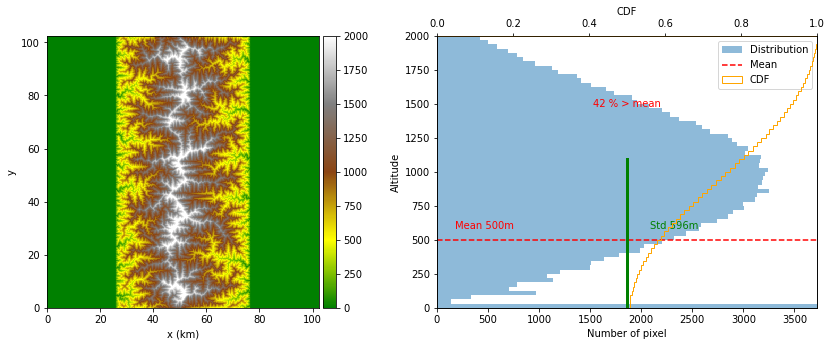

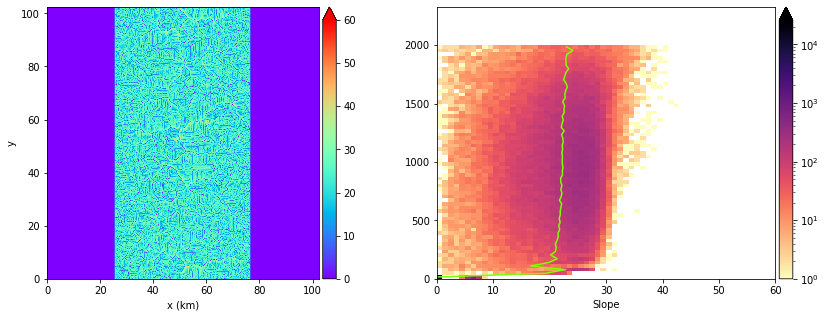

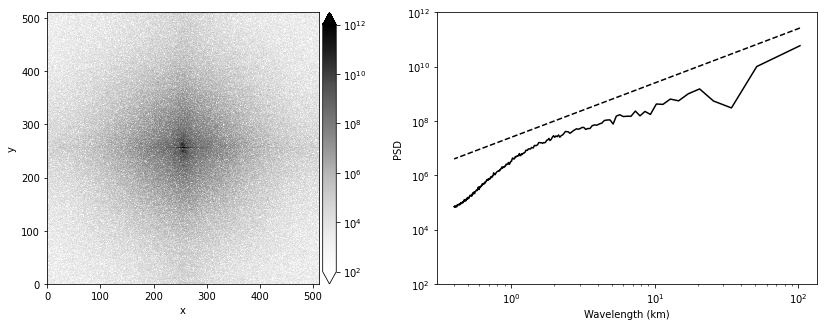

In [16]:
identity_card_ZS('MOPL_M200m')

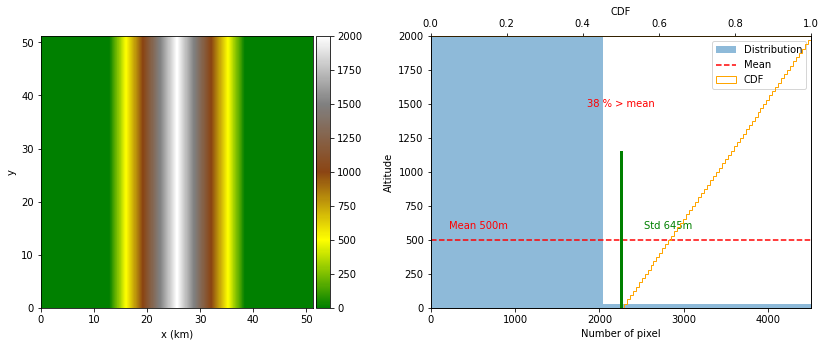

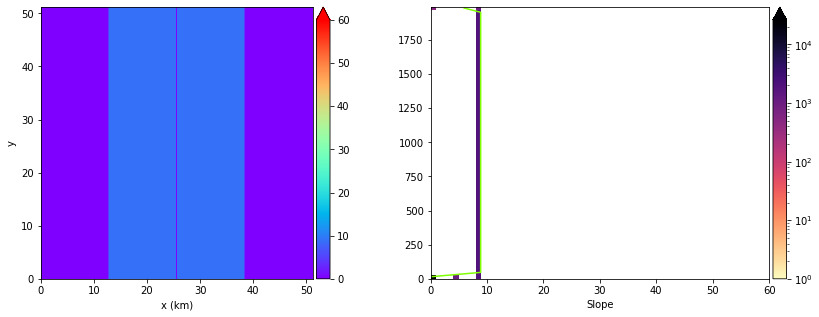

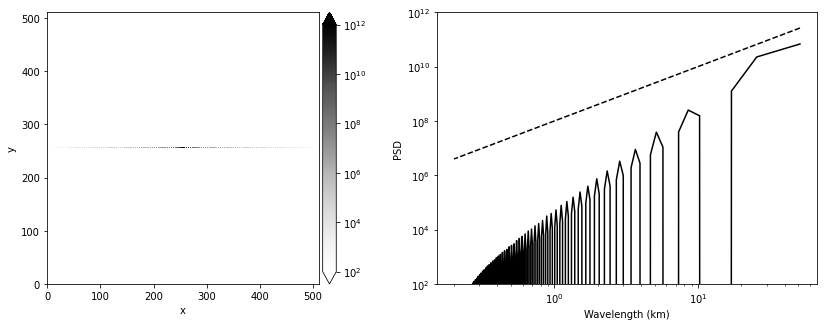

In [17]:
identity_card_ZS('TRI2_M100m')

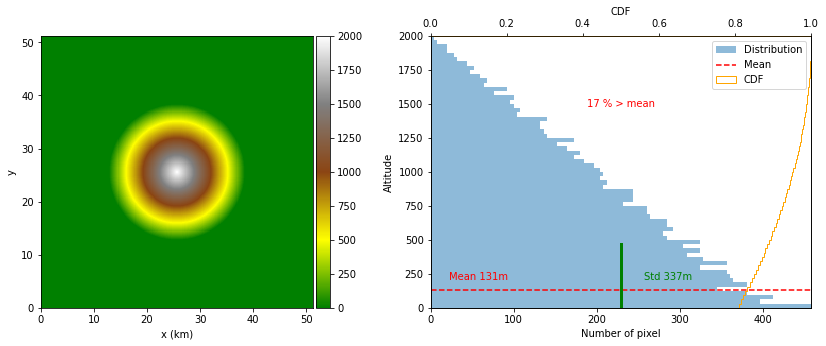

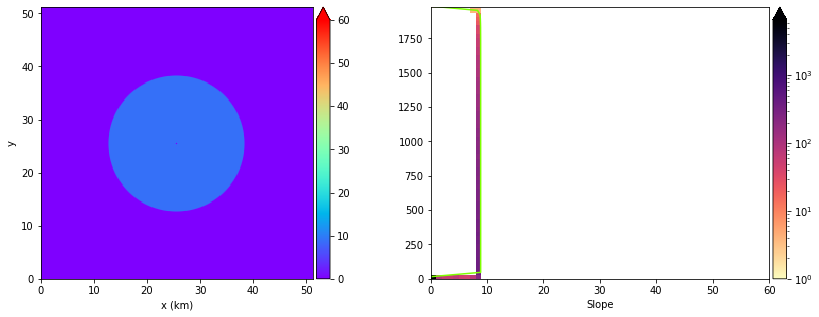

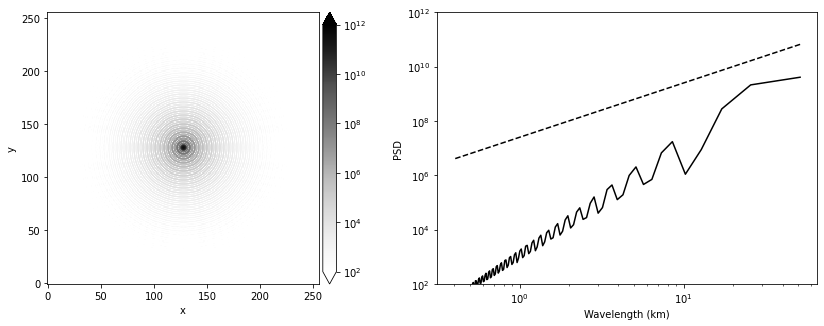

In [18]:
identity_card_ZS('CON2_S200m')

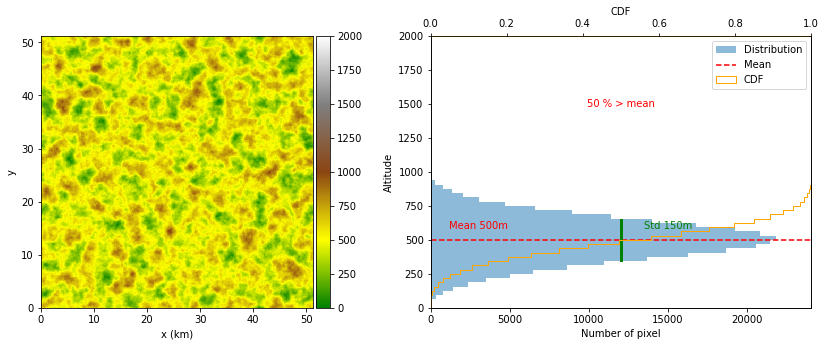

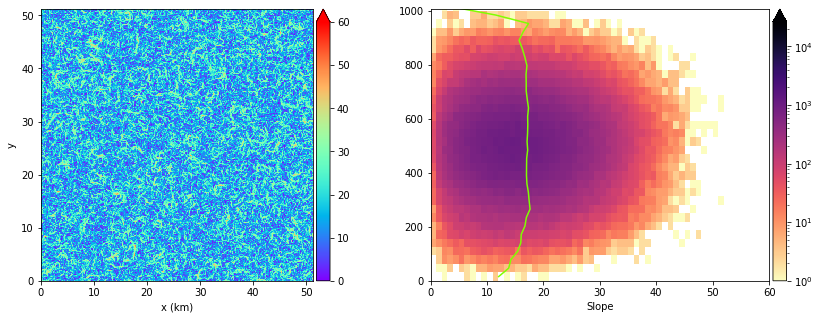

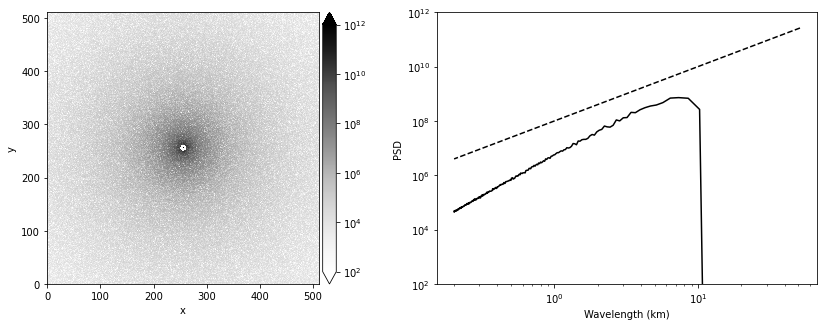

In [19]:
identity_card_ZS('MO10_M100m')

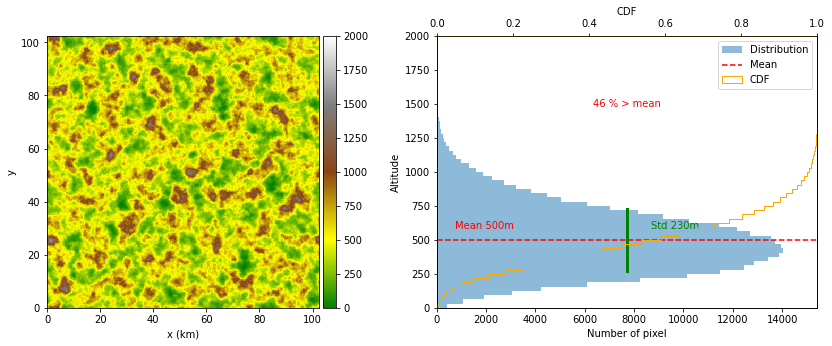

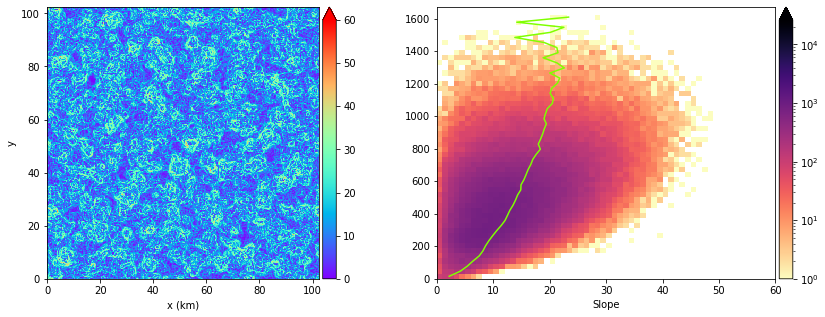

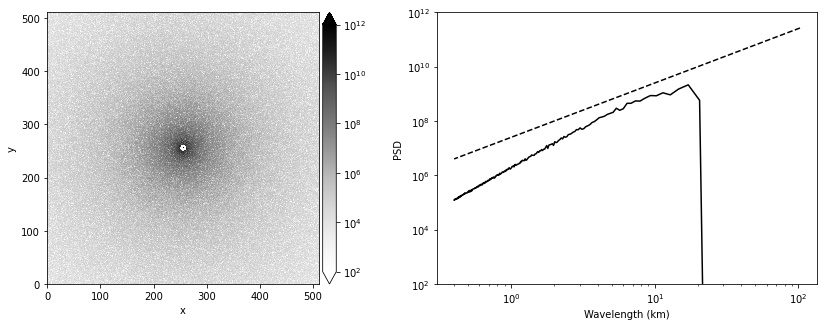

In [20]:
identity_card_ZS('MO20_M200m')

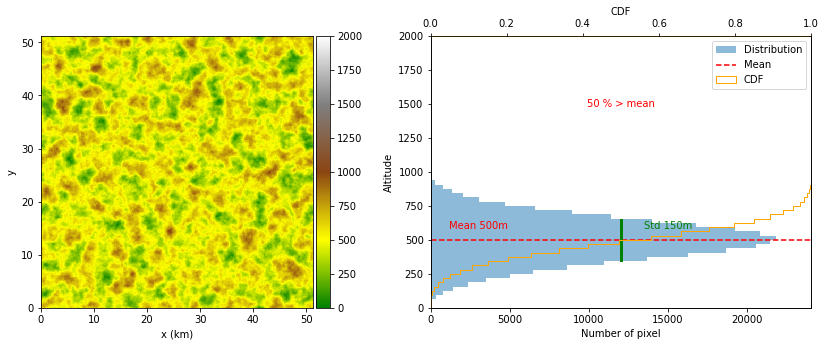

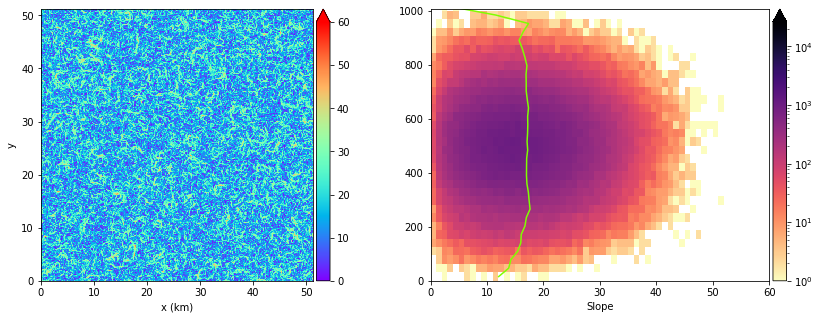

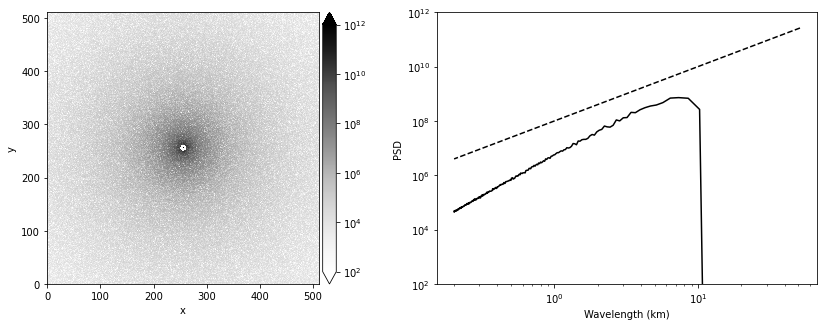

In [21]:
identity_card_ZS('MO10_M100m')

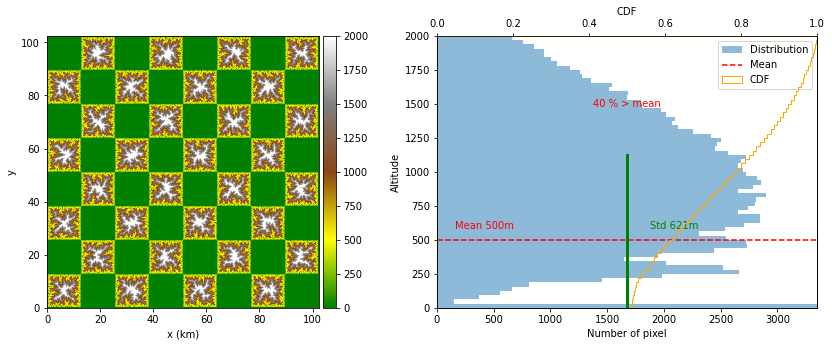

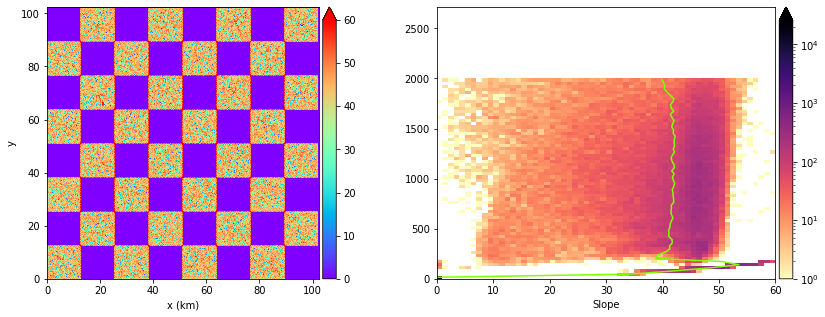

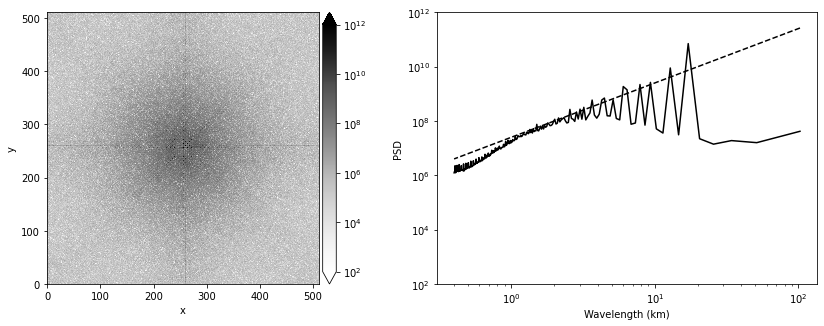

In [22]:
identity_card_ZS('MPT8_M200m')

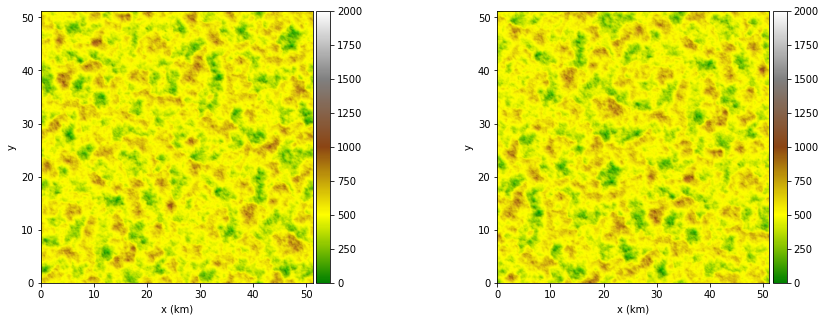

In [23]:
check_cyclicity('MO10_M100m')